tsne experiments: 

- sample size
- number of nearest neighbors (perplexity)
- 3 components

In [1]:
# load conda environment

# %matplotlib notebook


import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")


sys.path.append("/homes/dgurvic/")
import master_functions


# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [11:45:03] Enabling RDKit 2019.09.2 jupyter extensions


## Import Data

In [2]:
e_coli_wild_efflux_feats = pd.read_pickle("data/co_add_efflux_ecoli.pkl") 

e_coli_wild_efflux = pd.read_pickle("data/e_coli_wild_efflux.pkl")

tsne_result = pd.read_pickle("tsne_results/tsne_result_sample_30k.pkl") # tsne result

index_efflux = pd.read_csv('mmpa_e_coli/index_efflux_final.csv') # result from my own mmpa

index_efflux_clean_len_stat = pd.read_pickle('data/index_efflux_clean_len_stat.pkl') # mmpa_clean

mmpa_zero =  pd.read_pickle("data/mmpa_zero.pkl") # final mmpa_cleaned_filtered

mmpa_zero_neg_pos = pd.read_pickle('data/mmpa_zero_neg_pos.pkl')

mmpa_zero_pos = mmpa_zero_neg_pos[mmpa_zero_neg_pos['t-stat']>0]
mmpa_zero_neg = mmpa_zero_neg_pos[mmpa_zero_neg_pos['t-stat']<0]

In [5]:
index_efflux

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
0,CN\C(NCCSCc1ccc(CN(C)C)o1)=C/[N+]([O-])=O.Cl,CN\C(NCCSCc1csc(CN(C)C)n1)=C/[N+]([O-])=O,24435,55220,[*:1]NCCSCc1ccc([*:2])o1>>[*:1]NCCSCc1csc([*:2...,[*:1]/C(=C/[N+](=O)[O-])NC.[*:2]CN(C)C,16.52,6.05,-10.47,[*:1]NCCSCc1ccc([*:2])o1,[*:1]NCCSCc1csc([*:2])n1
1,C(=C/c(cc1)ccc1F)(/NC(c2ccccc2)=O)\C(=O)OC(C)C,C(=C\c(cc1)ccc1F)(/C(OCC)=O)\NC(c2ccccc2)=O,47835,48891,[*:1]C(=O)OC(C)C>>[*:1]C(=O)OCC,[*:1]/C(=C/c1ccc(F)cc1)NC(=O)c1ccccc1,6.67,2.79,-3.88,[*:1]C(=O)OC(C)C,[*:1]C(=O)OCC
2,C(=C/c(cc1)ccc1F)(/NC(C)=O)\C(=O)NC(C(C)C)C(O)=O,C(=C/c(cc1)ccc1F)(/NC(C)=O)\C(OCC)=O,55660,63289,[*:1]C(=O)NC(C(=O)O)C(C)C>>[*:1]C(=O)OCC,[*:1]/C(=C/c1ccc(F)cc1)NC(C)=O,-1.58,5.93,7.51,[*:1]C(=O)NC(C(=O)O)C(C)C,[*:1]C(=O)OCC
3,C(=C\c(cc1)cc(c1OC(C)=O)OC)(/C(NCC=C)=O)\NC(c2...,C(=C\c(cc1)cc(c1OC(C)=O)OC)(/C(=O)NCc2ccccc2)\...,27527,23185,[*:1]C(=O)NCC=C>>[*:1]C(=O)NCc1ccccc1,[*:1]/C(=C/c1ccc(OC(C)=O)c(OC)c1)NC(=O)c1ccccc1,6.09,18.06,11.97,[*:1]C(=O)NCC=C,[*:1]C(=O)NCc1ccccc1
4,C(=C\c(cc1)cc(c1OC(C)=O)OC)(/C(=O)NCc2ccccc2)\...,C(=C/c(cc1)cc(c1OC(C)=O)OC)(/NC(c2ccccc2)=O)\C...,23185,68447,[*:1]C(=O)NCc1ccccc1>>[*:1]C(=O)Nc1ccccc1C,[*:1]/C(=C/c1ccc(OC(C)=O)c(OC)c1)NC(=O)c1ccccc1,18.06,13.22,-4.84,[*:1]C(=O)NCc1ccccc1,[*:1]C(=O)Nc1ccccc1C
...,...,...,...,...,...,...,...,...,...,...,...
1503616,N1(Cc2ccccc2)Sc3c(ccc(c3)[N+](=O)[O-])C1=O,N1(c2ccccc2)Sc3c(ccc(c3)[N+](=O)[O-])C1=O,74531,17089,[*:1]Cc1ccccc1>>[*:1]c1ccccc1,[*:1]n1sc2cc([N+](=O)[O-])ccc2c1=O,8.97,8.72,-0.25,[*:1]Cc1ccccc1,[*:1]c1ccccc1
1503617,N1(c2ccccc2)Sc3c(ccc(c3)[N+](=O)[O-])C1=O,[N+](=O)([O-])c(cc1)cc(c12)SNC2=O,17089,52339,[*:1]c1ccccc1>>[*:1][H],[*:1]n1sc2cc([N+](=O)[O-])ccc2c1=O,8.72,2.22,-6.50,[*:1]c1ccccc1,[*:1][H]
1503618,C1(=O)N(C)Sc2c1ccc(c2)[N+](=O)[O-],N1(Cc2ccccc2)Sc3c(ccc(c3)[N+](=O)[O-])C1=O,67309,74531,[*:1]C>>[*:1]Cc1ccccc1,[*:1]n1sc2cc([N+](=O)[O-])ccc2c1=O,25.55,8.97,-16.58,[*:1]C,[*:1]Cc1ccccc1
1503619,C1(=O)N(C)Sc2c1ccc(c2)[N+](=O)[O-],[N+](=O)([O-])c(cc1)cc(c12)SNC2=O,67309,52339,[*:1]C>>[*:1][H],[*:1]n1sc2cc([N+](=O)[O-])ccc2c1=O,25.55,2.22,-23.33,[*:1]C,[*:1][H]


In [6]:
index_efflux_clean_len_stat

,smirks,dof,t-stat,p-val (t-test),measurement_delta,std,sem
0,[*:1]C>>[*:1][H],4957,4.159994,3.236402e-05,0.988310,16.728371,0.237575
1,[*:1]OC>>[*:1][H],4792,0.918132,3.585962e-01,0.204838,15.445784,0.223103
2,[*:1]Cl>>[*:1][H],2922,-0.064045,9.489390e-01,-0.018710,15.794651,0.292143
3,[*:1]Br>>[*:1][H],2193,2.496682,1.260900e-02,0.996841,18.701706,0.399267
4,[*:1]c1ccc([*:2])cc1>>[*:1]c1cccc([*:2])c1,2073,5.029380,5.343910e-07,1.593799,14.431902,0.316898
...,...,...,...,...,...,...,...
55233,[*:1]c1cc(Br)ccc1OCC>>[*:1]c1cccc(F)c1,2,1.097153,3.870313e-01,7.140000,11.271757,6.507752
55234,[*:1]c1cc([*:2])c(O)cc1[*:3]>>[*:2]c1cc(Br)c([...,2,0.724295,5.441532e-01,5.030000,12.028545,6.944684
55235,[*:1]/C=N/NC(=O)C(C)SC[*:2]>>[*:2]/C=N/NC(=O)C...,2,-3.059121,9.230179e-02,-9.926667,5.620403,3.244941
55236,[*:1]c1ccc(Cl)c(Cl)c1>>[*:1]c1ccc(OC(C)=O)cc1,2,0.398820,7.285780e-01,4.073333,17.690230,10.213459


In [8]:
mmpa_zero_neg_pos

,smirks,dof,t-stat,p-val (t-test),measurement_delta,std,sem,LHS,RHS
0,[*:1]CNC(=O)CO[*:2]>>[*:1]N1C(=O)C(O)=CC1([*:2])O,3,107.830725,1.758364e-06,95.750,1.775932,0.887966,[*:1]CNC(=O)CO[*:2],[*:1]N1C(=O)C(O)=CC1([*:2])O
1,[*:1]/C=N/C([*:2])/N=C/[*:3]>>[*:1][P+]([*:2])...,3,17.127315,4.336094e-04,92.760,10.831820,5.415910,[*:1]/C=N/C([*:2])/N=C/[*:3],[*:1][P+]([*:2])([*:3])Cc1cccc(N)c1
2,[*:1]/C=N/C([*:2])/N=C/[*:3]>>[*:1]Nc1cn([*:2]...,3,16.972216,4.455064e-04,91.920,10.831820,5.415910,[*:1]/C=N/C([*:2])/N=C/[*:3],[*:1]Nc1cn([*:2])c(CCC)[n+]1[*:3]
3,[*:1]Nc1nc([*:2])nc(Cl)n1>>[*:1]Nc1nc([*:2])nc...,2,45.207921,4.889364e-04,91.320,3.498743,2.020000,[*:1]Nc1nc([*:2])nc(Cl)n1,[*:1]Nc1nc([*:2])nc(NN)n1
4,[*:1]/C=N/C([*:2])/N=C/[*:3]>>[*:1][P+]([*:2])...,3,16.809732,4.584403e-04,91.040,10.831820,5.415910,[*:1]/C=N/C([*:2])/N=C/[*:3],[*:1][P+]([*:2])([*:3])Cc1ccc(N)cc1
...,...,...,...,...,...,...,...,...,...
9161,[*:1]CCN(C)C>>[*:1]CCN1CCCC1=O,8,-263.693281,4.789009e-17,-98.570,1.121417,0.373806,[*:1]CCN(C)C,[*:1]CCN1CCCC1=O
9162,[*:1]/C=C(/C([*:2])=O)n1cncn1>>[*:2]C[C@H](NC(...,3,-7.514272,4.884175e-03,-105.970,28.204995,14.102497,[*:1]/C=C(/C([*:2])=O)n1cncn1,[*:2]C[C@H](NC([*:1])=O)C(N)=O
9163,[*:1]c1ccc2ccccc2n1>>[*:1]c1ccc2nonc2c1,3,-5.986499,9.331686e-03,-118.215,39.493868,19.746934,[*:1]c1ccc2ccccc2n1,[*:1]c1ccc2nonc2c1
9164,[*:1]N(C)C>>[*:1][N+]1([O-])CCCCC1,8,-472.331193,4.520526e-19,-176.560,1.121417,0.373806,[*:1]N(C)C,[*:1][N+]1([O-])CCCCC1


In [3]:
# import master data
inhibition = pd.read_csv('all_co_add_data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('all_co_add_data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


## t-SNE

In [55]:
def tsne(df, sample_size, perp, label ):
    
    sample = df.sample(sample_size).values

    tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(sample) # similartity matrix 
    n_mol = len(sample)
    similarity_matrix = np.ones([n_mol,n_mol])
    i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
    i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
    similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
    similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
    distance_matrix = np.subtract(1,similarity_matrix) 

    TSNE_sim = TSNE(verbose=1, n_components=2, init='pca', method='barnes_hut', perplexity=perp).fit_transform(distance_matrix) 
    
    
    tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) 
    
    plt.rcParams['axes.linewidth'] = 1.5
    fig, ax = plt.subplots(figsize=(12,12))

    ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, s=60 ,alpha=0.8, hue=label) #, palette=["C0", "C1"])
    
    plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

    plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

    plt.tick_params ('both',width=2,labelsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()

    #ax.legend(handles=handles[1:], labels=labels[1:])

    #plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

    plt.tight_layout()
    plt.show()
    
    plt.rcParams['axes.linewidth'] = 1.5
    
    fig, ax = plt.subplots(figsize=(12,12))

    ax=sns.kdeplot(x='TC1',y='TC2',data=tsne_result,alpha=0.8, levels=5, hue=label) # , palette=["C0", "C1"])

    plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

    plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

    plt.tick_params ('both',width=2,labelsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    handles, labels = ax.get_legend_handles_labels()

    #ax.legend(handles=handles[1:], labels=labels[1:])

    #plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

    plt.tight_layout()
    plt.show()


In [5]:

def tsne_3d(df, sample_size, perp ):
    
    sample = df.sample(sample_size).values

    tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(sample) # similartity matrix 
    n_mol = len(sample)
    similarity_matrix = np.ones([n_mol,n_mol])
    i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
    i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
    similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
    similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
    distance_matrix = np.subtract(1,similarity_matrix) 

    TSNE_sim = TSNE(verbose=1, n_components=3, init='pca', method='barnes_hut', perplexity=perp).fit_transform(distance_matrix) 


    tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2", 'TC3']) 

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection = '3d')

    x = tsne_result['TC1']
    y = tsne_result['TC2']
    z = tsne_result['TC3']

    ax.scatter(x, y, z)

    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 4.778s...
[t-SNE] Computed neighbors for 5000 samples in 537.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.926570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.360809
[t-SNE] KL divergence after 1000 iterations: 1.231309


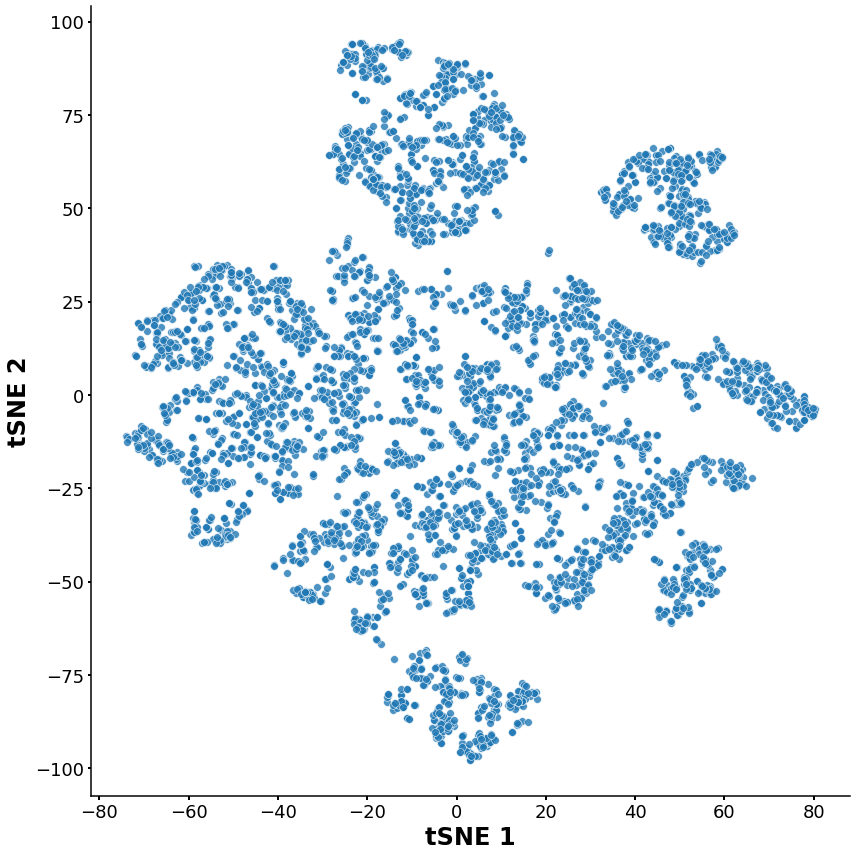

In [22]:
tsne(e_coli_wild_efflux_feats['fps'], 5000, 30)

In [11]:
%matplotlib qt


tsne_3d(e_coli_wild_efflux_feats['fps'], 2000, 100)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.239s...
[t-SNE] Computed neighbors for 2000 samples in 15.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.748158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.795532
[t-SNE] KL divergence after 1000 iterations: 0.781778


<IPython.core.display.Javascript object>

In [ ]:
tsne(e_coli_wild_efflux_feats['fps'], 5000, 100)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.844s...
[t-SNE] Computed neighbors for 5000 samples in 209.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.088851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.490166
[t-SNE] KL divergence after 1000 iterations: 1.211446


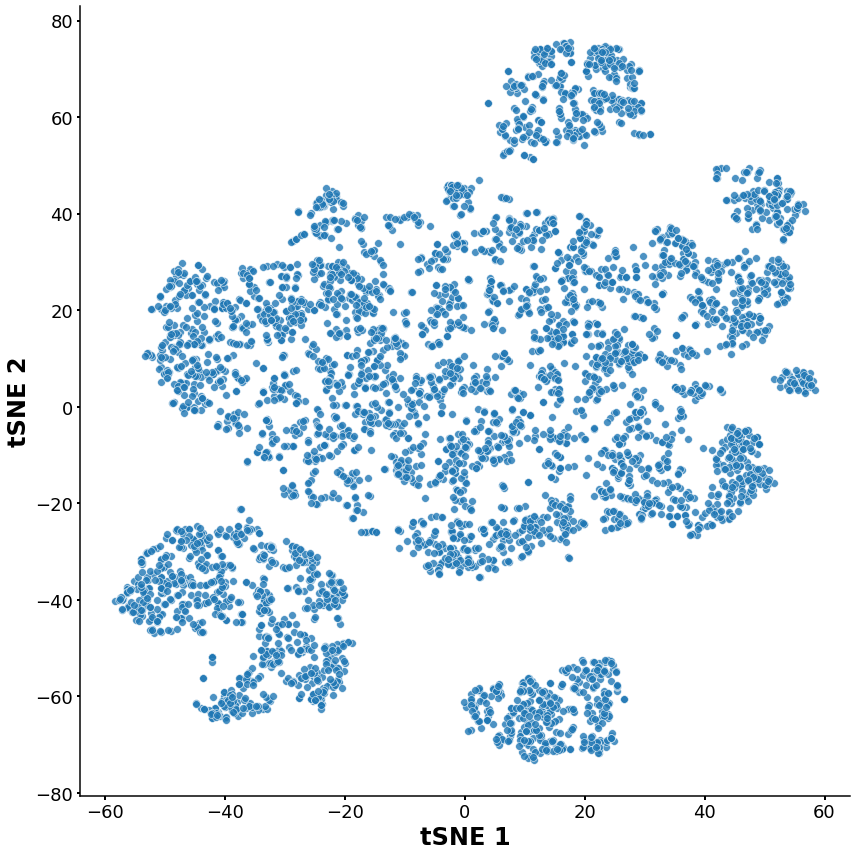

In [24]:
tsne(e_coli_wild_efflux_feats['fps'], 5000, 50)

In [7]:
tsne_result

,TC1,TC2
0,48.871262,17.796469
1,2.626062,3.879985
2,-62.328079,30.826286
3,-4.055226,33.535389
4,-48.515747,-20.978548
...,...,...
29995,75.544067,-23.626493
29996,-41.551601,33.695808
29997,7.750478,-6.004726
29998,-30.259977,13.598530


In [ ]:

# efflux agonist (inactive) / control

# if compound scored higher when efflux removed : efflux agonist

# if compounds scored lowe/same : efflux ignorant

e_coli_wild_efflux['label'] = np.where((e_coli_wild_efflux['INHIB_AVE_wild'] <= e_coli_wild_efflux['INHIB_AVE_efflux']), 'efflux agonist', 'efflux ignorant')

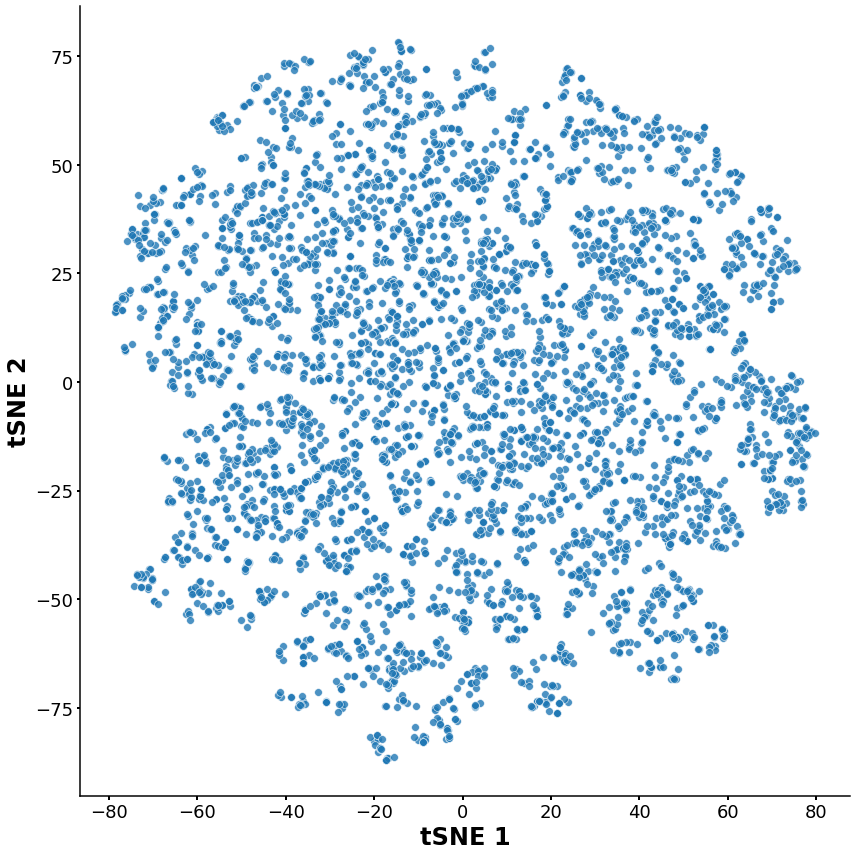

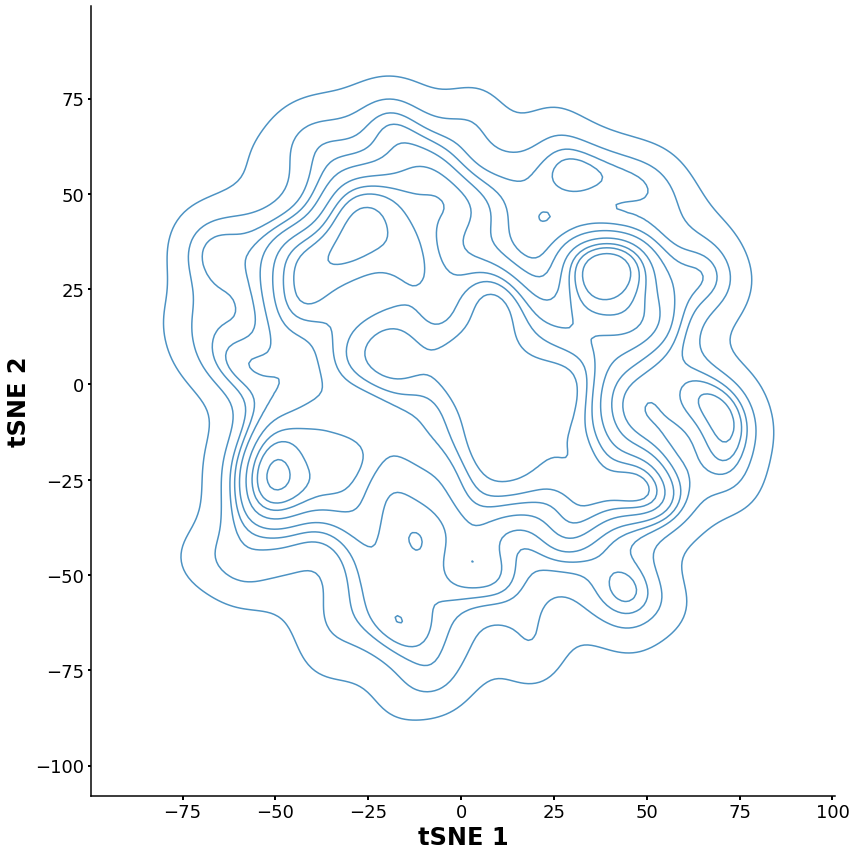

In [6]:
# no label

data=tsne_result.sample(5000)

plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(12,12))

ax=sns.scatterplot(x='TC1',y='TC2',data=data, s=60 ,alpha=0.8) #, palette=["C0", "C1"])
        
plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()


plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(12,12))

ax=sns.kdeplot(x='TC1',y='TC2',data=tsne_result,alpha=0.8, levels=10) # , palette=["C0", "C1"])
        
plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

## tsne of efflux

In [2]:
# label compounds based on substrate or not, 

efflux_e_coli = pd.read_csv('mmpa_e_coli/efflux_e_coli.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b0fc9f33cd0>]],
      dtype=object)

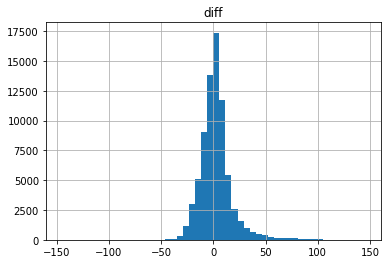

In [3]:
efflux_e_coli.hist(bins=50)

In [4]:
zero_diff = efflux_e_coli[(efflux_e_coli['diff']<5)&(efflux_e_coli['diff']>-5)]
zero_diff['label'] = 'not_substrate'

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
posiitive_diff = efflux_e_coli[(efflux_e_coli['diff']>5)]
posiitive_diff['label'] ='substrate'

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
posiitive_diff.append(zero_diff).to_csv('data/substrate_not.csv', index=False)

In [51]:
efflux_tsne_sample = posiitive_diff.append(zero_diff).sample(5000)

In [52]:
efflux_tsne_sample.label

26295    not_substrate
43209        substrate
57703    not_substrate
33233    not_substrate
46285        substrate
             ...      
71880    not_substrate
10748    not_substrate
25556    not_substrate
16562        substrate
65458        substrate
Name: label, Length: 5000, dtype: object

## t-sne

In [53]:
efflux_tsne_sample['Mol']= efflux_tsne_sample['SMILES'].apply(Chem.MolFromSmiles)

efflux_tsne_sample_fps =  [MACCSkeys.GenMACCSKeys(x) for x in efflux_tsne_sample['Mol']] #  MACCSKeys

efflux_tsne_sample['fps'] = efflux_tsne_sample_fps

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.962s...
[t-SNE] Computed neighbors for 5000 samples in 251.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.365044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.092484
[t-SNE] KL divergence after 1000 iterations: 1.157949


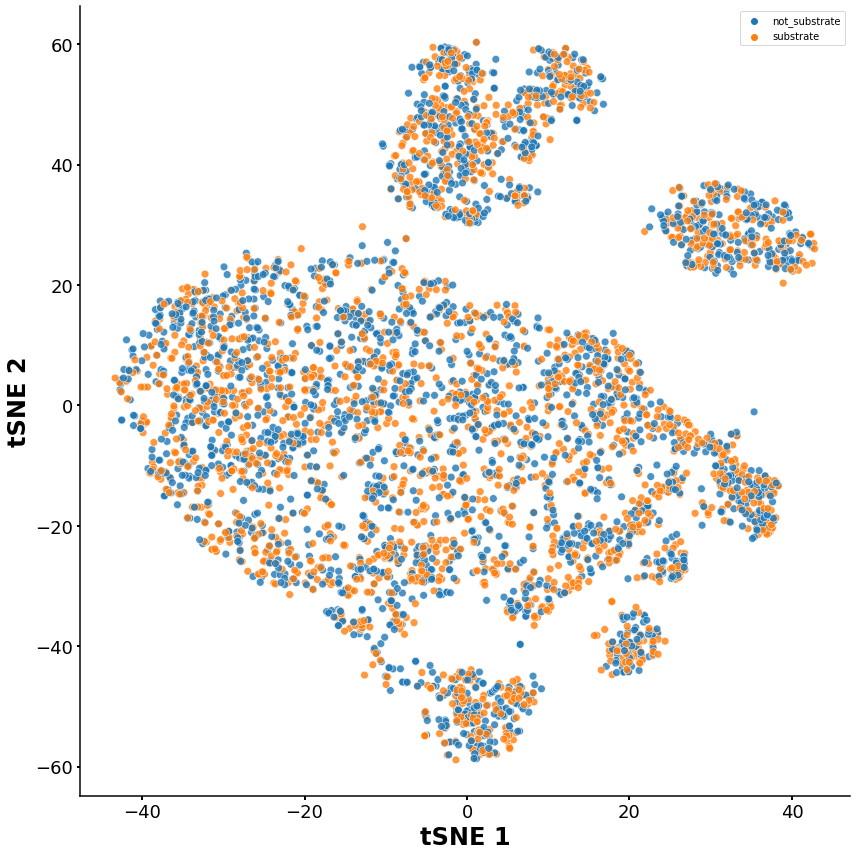

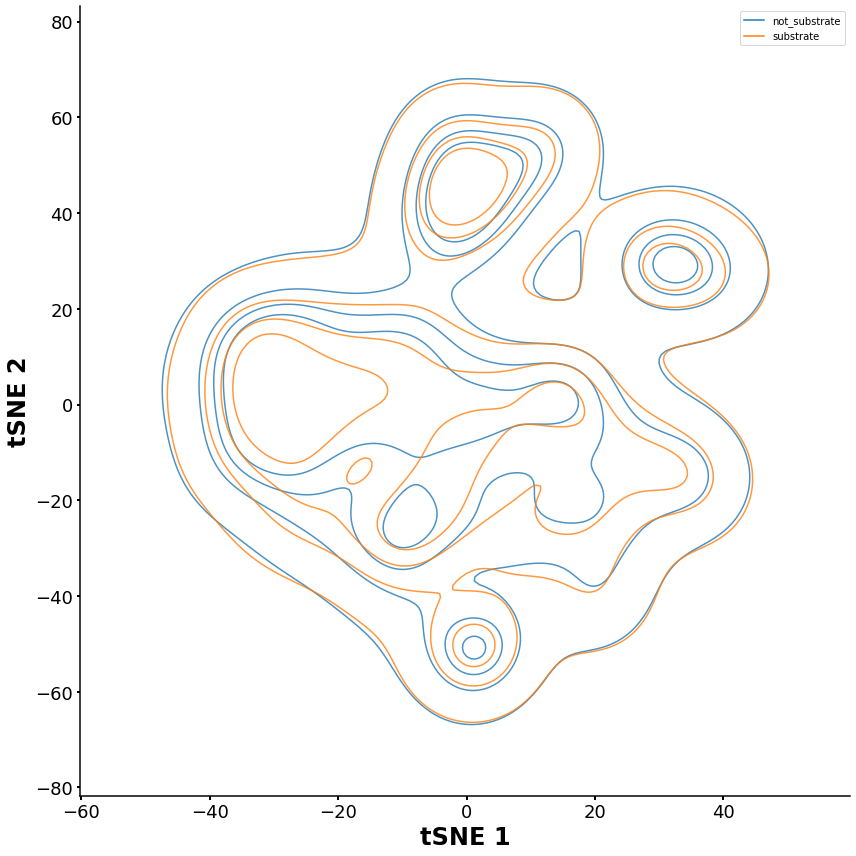

In [56]:
tsne(efflux_tsne_sample['fps'], 5000, 100, efflux_tsne_sample.label.values)

In [20]:
efflux_e_coli[(efflux_e_coli['diff']<-5)]

,SMILES,diff
1,N1(c2ccc(c(C)c2)C)C(=O)\C(\C(C)=N1)=C\NNC(=O)c...,-11.80
3,C(=O)(Nc(cccc1C(=O)N\N=C\c(cc2)ccc2Cl)c1)c3ccc...,-10.76
26,C1(=O)N(c(cc2)ccc2[N+](=O)[O-])Cc(ccc(OC)c3OC)c13,-5.62
41,N1(c2cccc(C)c2)C(=O)c(c3C1=O)ccc(C(OCCCC)=O)c3,-5.37
42,c1(c(ccc(c1)[N+](=O)[O-])N\N=C(/CC)\Nc(cc2)ccc...,-9.78
...,...,...
75025,c1(C#N)c2c(sc1\N=C\c(ccc(c3OC)OCC(O)=O)c3)CCC2,-7.37
75027,c(c(OC)c1)(c(OC)cc1C(=S)N(CC2)CCO2)OC(c3ccccc3)=O,-6.85
75038,C(C#N)(C(c1ccc(C(C)(C)C)s1)C2=C(N3c4ccc(cn4)Br...,-10.85
75053,C(=O)(Nc(cc1)ccc1OC)C(NCCN(CC2)CCO2)=O,-5.60


## end

## MMPA

mmpa on e.coli ['smiles', 'efflux - wild']

In [5]:
e_coli_wild_efflux['diff']  = e_coli_wild_efflux['INHIB_AVE_efflux'] - e_coli_wild_efflux['INHIB_AVE_wild'] # mmpa activity

In [7]:
e_coli_wild_efflux[['SMILES', 'diff']].to_csv('efflux_e_coli.csv', index=False) # save file for mmpa

Carry out mmpa !

    1. python(file, name) -> smiles.smi and prop.csv
    2. bash(smiles.smi) -> out.fragment, out.csv
    3. python(out.csv, prop.csv)
	

python main/parse.py $1 $2

smi=$".smi"

frag=$".fragments"

python mmpdb/mmpdb fragment "$2$smi" -o "$2$frag"
python mmpdb/mmpdb index "$2$frag" -o "index_$2.csv"

python main/add_prop.py "index_$2.csv" "$2_property.csv" 

what are we optimising mmpa for?


delta_efflux - wild ->  would mean that if diff is positive a compound scored higher with no efflux present, which means compound activates efflux.
                        if the diff is negative/0 the compound did not activate efflux.
                        
                        
the mmpa produces diff of diff = measurement_delta, so:
                        increase would mean activates more?
                        decrease in diff means activates less?

filter mmpa data:

    RHS or LHS must contain less heavy atoms than common core
    Calculate statistics for every pair 
    filter statistics based on p-val

In [4]:
index_efflux_clean_len = master_functions.clean_mmpa_pairs_len(index_efflux) # filter pairs by len LHS & RHS vs CORE

In [10]:
index_efflux_clean_len_stat = master_functions.stat_it_2(index_efflux_clean_len)

index_efflux_clean_len_stat.to_pickle("index_efflux_clean_len_stat.pkl")

55238
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000


In [20]:
mmpa_zero_neg_pos = master_functions.zero_in(index_efflux_clean_len_stat, pos=False) #  is this filtering for positive?


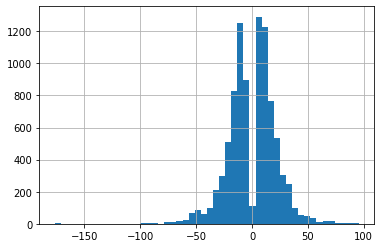

In [10]:
mmpa_zero_neg_pos.measurement_delta.hist(bins=50)

In [27]:
mmpa_zero_pos = mmpa_zero_neg_pos[mmpa_zero_neg_pos['t-stat']>0]
print('pos len:', len(mmpa_zero_pos))

pos len: 4752


In [28]:
mmpa_zero_neg = mmpa_zero_neg_pos[mmpa_zero_neg_pos['t-stat']<0]
print('neg len:', len(mmpa_zero_neg))

neg len: 4414


In [7]:
mmpa_zero_neg_pos = master_functions.split_transition(mmpa_zero_neg_pos, 'smirks')

In [8]:
mmpa_zero_neg_pos.to_pickle("mmpa_zero_neg_pos.pkl")

## To simplify pairs resulting in pos and neg change in activity I want to featurise the structual change in terms of functional groups

In [23]:
features_all_neg, l_feats_neg, r_feats_neg = master_functions.calculate_fractions_mk4(mmpa_zero_neg)

features_all_pos, l_feats_pos, r_feats_pos = master_functions.calculate_fractions_mk4(mmpa_zero_pos)

  1%|          | 34/4414 [00:00<00:13, 334.07it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


  1%|          | 31/4752 [00:00<00:15, 301.13it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 4752/4752 [00:15<00:00, 309.83it/s]


### Neg

In [29]:
to_drop = ['arene', 'heteroarene', 'alkyne', 'benzene ring', 'amine', 'azaarene', 'alkene', 'aryl halide', 'alkyl halide', 'leaving group', 'alkenyl halide']

features_all_dropped_neg = features_all_neg.drop(to_drop, axis = 1)

l_feats_dropped_neg =  l_feats_neg.drop(to_drop, axis = 1)
r_feats_dropped_neg =  r_feats_neg.drop(to_drop, axis = 1)

# fractions_to_drop=['fr_ketone_Topliss', 'fr_Al_OH_noTert', 'fr_Ar_N', 'fr_methoxy', 'fr_C_O', 'fr_phenol_noOrthoHbond' ]
# fractions above are kept as significant but not looked at on the exchange

fr_sig_descriptors_neg = master_functions.find_sig_feats_mk2(l_feats_dropped_neg, r_feats_dropped_neg, 0.01)

Found significant fractions:  30


In [32]:
#fr_sig_descriptors.remove('fr_NH0')
fractions_to_drop=[]

# res_neg= master_functions.results_arr(features_all.drop(columns=['fr_NH0']), fr_sig_descriptors, r_feats, l_feats, fractions_to_drop )
res_neg_neg= master_functions.results_arr(features_all_dropped_neg, fr_sig_descriptors_neg, r_feats_dropped_neg, l_feats_dropped_neg, fractions_to_drop )

aniline has positive correlation 
phenol has negative correlation 
amidine has negative correlation 
primary amine has positive correlation 
secondary amine has negative correlation 
enamine has negative correlation 
iminyl has negative correlation 
nitrile has positive correlation 
percentage gain under -100
alkoxylamine has negative correlation 
carbamate has positive correlation 
percentage gain under -100
carboxamide has negative correlation 
primary carboxamide has positive correlation 
secondary carboxamide has negative correlation 
second gain
['aniline', ('primary amine', 'nitrile'), 'aryl chloride']
[12.5, 6.58, 5.26]
tertiary carboxamide has negative correlation 
second gain
['carboxylic acid', ('iminyl', 'oxime ether'), 'alkanol']
[14.12, 12.94, 11.76]
urethane has positive correlation 
percentage gain under -100
aldehyde has positive correlation 
alkanol has negative correlation 
α,β-unsaturated carbonyl has negative correlation 
second gain
['iminyl', ('oxime ether', 'carb

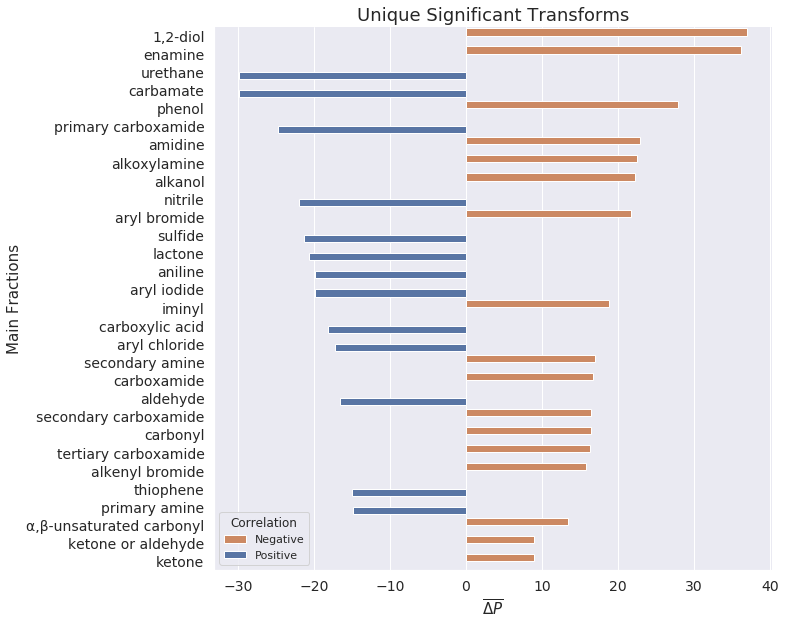

In [33]:
master_functions.plot_feats(res_neg_neg)

### Pos

Found significant fractions:  31
phenol has positive correlation 
amidine has negative correlation 
aminal has negative correlation 
second gain
['carbonyl', ('carboxamide', 'alkanol'), 'secondary carboxamide']
[50.0, 34.21, 21.05]
percentage_loss 100
primary amine has positive correlation 
secondary amine has positive correlation 
tertiary amine has negative correlation 
enamine has negative correlation 
hydrazine has positive correlation 
percentage gain under -100
hydrazone has negative correlation 
percentage_loss 100
iminyl has negative correlation 
nitrile has negative correlation 
N-acylcarbamate or urea (mixed imide) has negative correlation 
percentage_loss 100
alkoxylamine has positive correlation 
carboxamide has positive correlation 
secondary carboxamide has positive correlation 
second double loss
['α,β-unsaturated carbonyl', ('ketone', 'ketone or aldehyde'), 'enamine']
[-23.59, -9.51, -8.8]
enamide has negative correlation 
second gain
['secondary amine', ('carboxamide',

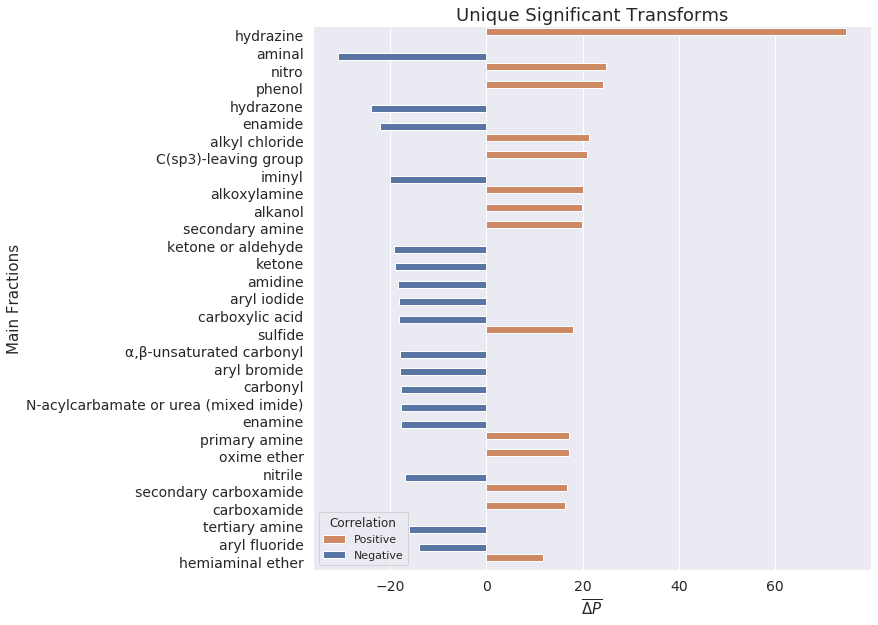

In [35]:
to_drop = ['arene', 'heteroarene', 'alkyne', 'benzene ring', 'amine', 'azaarene', 'alkene', 'aryl halide', 'alkyl halide', 'leaving group', 'alkenyl halide']

features_all_dropped_pos = features_all_pos.drop(to_drop, axis = 1)

l_feats_dropped_pos =  l_feats_pos.drop(to_drop, axis = 1)
r_feats_dropped_pos =  r_feats_pos.drop(to_drop, axis = 1)

# fractions_to_drop=['fr_ketone_Topliss', 'fr_Al_OH_noTert', 'fr_Ar_N', 'fr_methoxy', 'fr_C_O', 'fr_phenol_noOrthoHbond' ]
# fractions above are kept as significant but not looked at on the exchange

fr_sig_descriptors_pos = master_functions.find_sig_feats_mk2(l_feats_dropped_pos, r_feats_dropped_pos, 0.01)

#fr_sig_descriptors.remove('fr_NH0')
fractions_to_drop=[]

# res_neg= master_functions.results_arr(features_all.drop(columns=['fr_NH0']), fr_sig_descriptors, r_feats, l_feats, fractions_to_drop )
res_neg_pos= master_functions.results_arr(features_all_dropped_pos, fr_sig_descriptors_pos, r_feats_dropped_pos, l_feats_dropped_pos, fractions_to_drop )

master_functions.plot_feats(res_neg_pos)

In [36]:
res_neg_pos

,Main fraction,Correlation,$\overline{\Delta P}$,sem,std,dof,Opposite fraction 1,% of opposite 1,Opposite fraction 2,% of opposite 2,Opposite fraction 3,% of opposite 3
7,hydrazine,Positive,74.69,2.64,7.47,8,carbonyl,-87.50,alkanol,-62.50,carboxamide,-37.50
2,aminal,Negative,-30.72,4.08,25.13,38,carbonyl,50.00,"(carboxamide, alkanol)",34.21,secondary carboxamide,21.05
17,nitro,Positive,24.93,1.40,16.04,131,aryl bromide,-38.17,ether,-36.64,carbonyl,-12.98
0,phenol,Positive,24.31,1.01,16.43,264,ether,-14.39,aryl chloride,-9.09,carbonyl,-7.58
8,hydrazone,Negative,-23.97,2.07,16.27,62,alkanol,51.61,carboxamide,25.81,secondary amine,24.19
15,enamide,Negative,-22.02,2.31,8.33,13,secondary amine,61.54,"(carboxamide, alkanol)",46.15,secondary carboxamide,38.46
25,alkyl chloride,Positive,21.43,1.16,11.25,94,carbonyl,-50.00,"α,β-unsaturated carbonyl",-13.83,alkanol,-12.77
29,C(sp3)-leaving group,Positive,20.83,1.15,11.41,98,carbonyl,-50.00,"α,β-unsaturated carbonyl",-13.27,alkanol,-12.24
9,iminyl,Negative,-20.06,0.86,16.27,362,alkanol,29.01,secondary amine,16.85,alkoxylamine,9.67
12,alkoxylamine,Positive,20.01,1.10,12.26,125,carboxamide,-31.20,iminyl,-28.00,secondary carboxamide,-16.80


# DEV

In [6]:

def new_smarts():
    func_groups=pd.read_csv('fg_smarts.csv')
    
        #fetch all substructure definitions and calculate mosl for them
    print('Generating molecular objects from pre-defined substructures')
    mol_substructures=[]
    for substructure in func_groups.SMARTS:
        mol_substructures.append(Chem.MolFromSmarts(substructure))

    return mol_substructures,  func_groups.name.to_list()


def calculate_fractions_mk5(df):

    mol_substructures, name_substructure = new_smarts()

    name_substructure = name_substructure + ['smirks', 'target']

    # Comapre left hand side

    #     frame_left=pd.DataFrame(columns=name_substructure)

    frame_left=[]
    frame_right=[]

    print('Calcualting LHS+RHS matches')

    #for index in enumerate(df.LHS.values)):

    for index in tqdm(range(len(df))):  

        #grab structure
        frame_temp_left=pd.DataFrame(0, index=range(1), columns=name_substructure)
        frame_temp_right=pd.DataFrame(0, index=range(1), columns=name_substructure)

        #turn it into mol 
        try:
            mol_target_left=Chem.MolFromSmarts(df.LHS.values[index])
            mol_target_left.UpdatePropertyCache()
            mol_target_left = Chem.AddHs(mol_target_left)
            
        except TypeError:
            print('Error: ', index, target)

        try:
            mol_target_right=Chem.MolFromSmarts(df.RHS.values[index])
            mol_target_right.UpdatePropertyCache()
            mol_target_right = Chem.AddHs(mol_target_right)
        except TypeError:
            print('Error: ', index, target)    

        if type(mol_target_right) != Chem.rdchem.Mol or type(mol_target_left) != Chem.rdchem.Mol:

            print('failed to MolObject: ', index)


        frame_temp_left['smirks'] = df.smirks.values[index]
        frame_temp_left['target'] = df.measurement_delta.values[index]    

        for sub_nr, sub in enumerate(mol_substructures):
            print(sub, sub_nr)
            if mol_target_left.HasSubstructMatch(sub):
                frame_temp_left[name_substructure[sub_nr]] = [1]

        frame_temp_right['smirks'] = df.smirks.values[index]
        frame_temp_right['target'] = df.measurement_delta.values[index]    

        for sub_nr, sub in enumerate(mol_substructures):
            if mol_target_right.HasSubstructMatch(sub):
                frame_temp_right[name_substructure[sub_nr]] = [1]

        frame_left.append(frame_temp_left.values)
        frame_right.append(frame_temp_right.values)

    frame_left_df = pd.DataFrame(np.concatenate(frame_left), columns = name_substructure)
    # compare right hand side
    frame_right_df = pd.DataFrame(np.concatenate(frame_right), columns = name_substructure)

    diff = frame_right_df.iloc[:,:-2] - frame_left_df.iloc[:,:-2] 

    diff['smirks'] = frame_right_df['smirks']
    diff['target'] = frame_right_df['target']

    return diff.reset_index(drop=True), frame_left_df.reset_index(drop=True), frame_right_df.reset_index(drop=True)

  1%|          | 34/4414 [00:00<00:12, 337.71it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


  1%|          | 31/4752 [00:00<00:15, 301.74it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 4752/4752 [00:15<00:00, 307.48it/s]


  0%|          | 0/4414 [00:00<?, ?it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches
 0

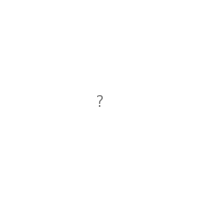

RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 36 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2019.09.2
	BOOST: 1_67


In [38]:
calculate_fractions_mk5(mmpa_zero_neg)

In [4]:
mol_target_right = Chem.MolFromSmarts(mmpa_zero_neg.LHS.values[0])
mol_target_right.UpdatePropertyCache()
mol_target_right = Chem.AddHs(mol_target_right)

In [1]:
mol_2 = new_smarts()[0][0]
# Chem.SanitizeMol(mol_2)

NameError: name 'new_smarts' is not defined

In [16]:
for i in range(0,900):
    print(i)
    mol = new_smarts()[0][i]
    Chem.FastFindRings(mol)
    mol_target_right.HasSubstructMatch(mol)

0
Generating molecular objects from pre-defined substructures


RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 36 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2019.09.2
	BOOST: 1_67


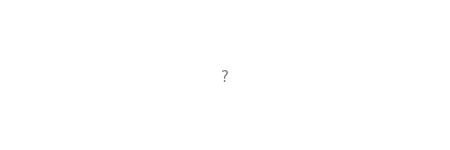

In [19]:
Chem.FastFindRings(mol)
mol


In [14]:
a

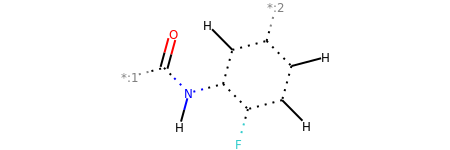

In [63]:
mol_target_right

In [67]:
mol.HasSubstructMatch(mol_2)

False

Generating molecular objects from pre-defined substructures


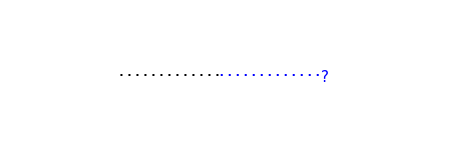

In [46]:
master_functions.generate_mols_for_substructures()[0][0]

In [51]:
mol_2 = new_smarts()[0][1]

Generating molecular objects from pre-defined substructures


# End DEV

In [65]:
mol_2